## Dog breed classifier

In this notebook we will build a dog breed classifier. The data is taken from the Kaggle competition Dog Breed Identification: https://www.kaggle.com/c/dog-breed-identification

The notebook is divided in the following sections:

1. Image loading and processing
2. Transfer learning and model tweaking
3. Model training
4. Model testing


In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### 1. Image loading and processing

#### Training dataset

In [2]:
df = pd.read_csv("labels.csv")
print(df.shape)

(10222, 2)


In [3]:
num_classes = df["breed"].nunique()
print(num_classes)

120


In [4]:
# Label encoding
le = LabelEncoder()
df["breed"] = le.fit_transform(df["breed"])

dog_breeds = le.classes_

#### Testing dataset

In [5]:
path = 'test'
csv_file = 'testing_names.csv'


# Write image names to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Names'])
    for folder, subfolders, filenames in os.walk(path):
        for img in filenames:
            img_name = folder + '/' + img
            writer.writerow([img_name])


df_test = pd.read_csv("testing_names.csv")

#### Training custom Data Loader

In [6]:
class CustomDataLoader(Dataset):
    def __init__(self, data, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0] + ".jpg")  # Get image name from CSV
        image = Image.open(img_name)
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)

        return image, label


train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


dataset = CustomDataLoader(data=df, root_dir='train/', transform=train_transform)

# Split the dataset into training and validation sets
test_size = 0.1
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=test_size)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Define the DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [7]:
print(f'Training images available per batch: {len(train_loader)}')
print(f'Testing images available per batch:  {len(val_loader)}')

Training images available per batch: 288
Testing images available per batch:  1023


#### Testing custom Data Loader

In [8]:
class TestDL(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data.iloc[idx, 0])  # Get image name from CSV
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)

        return image


test_transform = transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


test_dataset = TestDL(data=df_test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 2. Transfer learning and model tweaking

In [9]:
# Define VGG19 model
class VGG19(nn.Module):
    def __init__(self, num_classes=1000, pretrained=True):
        super(VGG19, self).__init__()
        # Load pre-trained VGG19 model
        self.vgg19 = models.vgg19(pretrained=pretrained)
        # Replace the last fully connected layer
        if pretrained:
            # Freeze all layers except the final fully connected layer
            for param in self.vgg19.parameters():
                param.requires_grad = False
        self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.vgg19(x)
        return F.log_softmax(x, dim=1)

# Test the network
model = VGG19(num_classes=num_classes, pretrained=True)
print(model)

c:\Users\Lenovo\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Co

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 3. Model training

Epoch [1/10], Train Loss: 1.0617
Epoch [2/10], Train Loss: 0.5760
Epoch [3/10], Train Loss: 0.5066
Epoch [4/10], Train Loss: 0.4509
Epoch [5/10], Train Loss: 0.4251
Epoch [6/10], Train Loss: 0.4026
Epoch [7/10], Train Loss: 0.4046
Epoch [8/10], Train Loss: 0.3689
Epoch [9/10], Train Loss: 0.3829
Epoch [10/10], Train Loss: 0.3720


Text(0.5, 1.0, 'Loss at the end of each epoch')

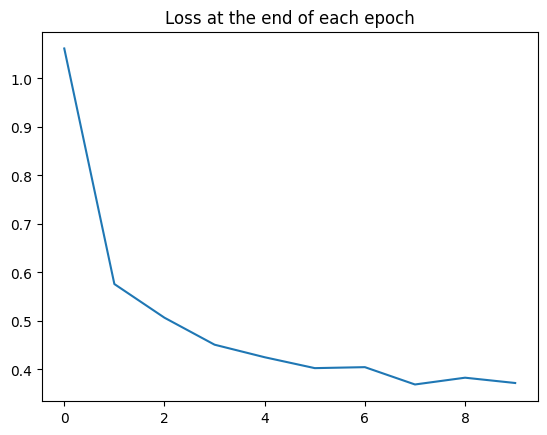

In [11]:
num_epochs = 10

train_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_loss.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')

plt.plot(train_loss)
plt.title('Loss at the end of each epoch')

In [17]:
torch.save(model.state_dict(), 'Dogsbreed.pt')

#### Validating the model

In [12]:
y_preds = []
y_vals = []

model.eval()
for inputs, labels in val_loader:
    outputs = model(inputs)
    y_pred = torch.max(outputs, 1)[1].item()
    y_preds.append(y_pred)
    y_vals.append(labels.item())

<Axes: >

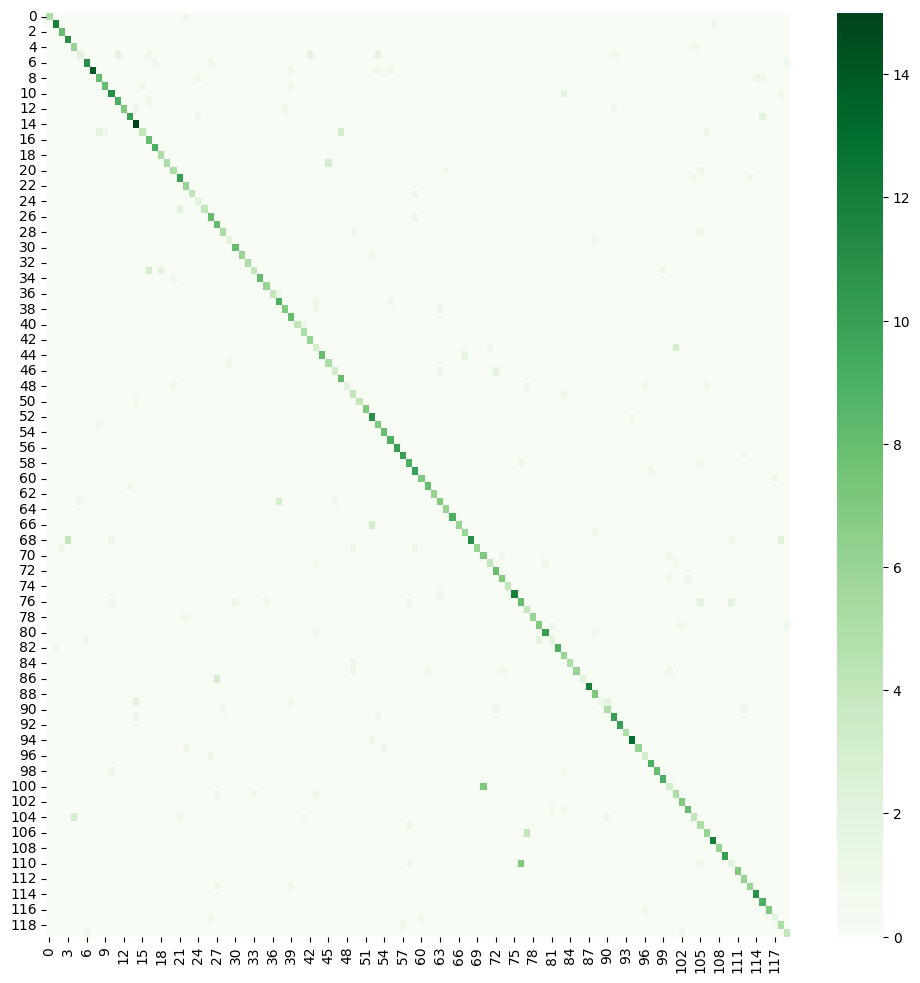

In [13]:
conf_matrix = confusion_matrix(y_pred=y_preds, y_true=y_vals)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, cmap="Greens")

### 4. Model evaluation

In [14]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

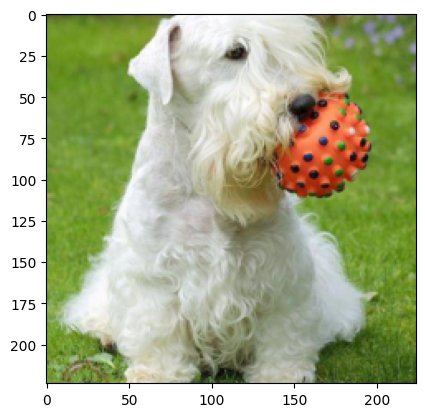

In [20]:
x = 2018
im = inv_normalize(test_dataset[x])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [21]:
model.eval()
with torch.no_grad():
    new_pred = model(test_dataset[x].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {dog_breeds[new_pred.item()]}')

Predicted value: 98 sealyham_terrier
